In [1]:
import sys
sys.path.append('stylegan2-pytorch')

In [2]:
import matplotlib.pyplot as plt
import torch

In [3]:
# from model import Generator
from utils import nethook
from utils.seqstylegan2 import SeqStyleGAN2

In [4]:
device = torch.device('cuda')

In [5]:
stylegan = SeqStyleGAN2(
    size=256, style_dim=512, n_mlp=8, truncation=1, mconv='seq')
stylegan.to(device)
_ = stylegan.requires_grad_(False)

In [6]:
ckpt = torch.load('./release/stylegan2-church-config-f.pt')
stylegan.load_state_dict(ckpt['g_ema'], latent_avg=ckpt['latent_avg'])

In [7]:
latent = torch.randn(1, 512, device=device)

In [8]:
sample = stylegan(latent.clone())
sample.shape

torch.Size([1, 3, 256, 256])

In [9]:
def postproc(sample):
    sample = sample.permute(0, 2, 3, 1).cpu().detach().numpy()
    min_, max_ = sample.min(axis=(1, 2, 3)), sample.max(axis=(1, 2, 3))
    sample = (sample - min_) / (max_ - min_)
    return sample

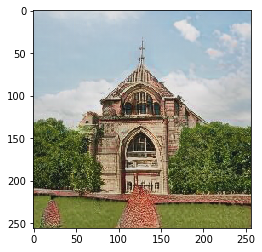

In [10]:
plt.imshow(postproc(sample)[0])

In [11]:
target_layer = 8

target_first = 'layer{}.sconv.mconv.dconv'.format(target_layer)
target_last = 'layer{}.sconv.activate'.format(target_layer)

context_model = nethook.subsequence(
    stylegan,
    upto_layer=target_first,
    share_weights=True)
target_model = nethook.subsequence(
    stylegan,
    first_layer=target_first,
    last_layer=target_last,
    share_weights=True)
render_model = nethook.subsequence(
    stylegan,
    after_layer=target_last,
    share_weights=True)

In [12]:
with torch.no_grad():
    context = context_model(latent.clone())
    size = context.output.size(-1)
    context.output.shape, context.fmap.shape

In [13]:
def make_patch(tensor, unit):
    # B, C, H, W
    b, c, h, w = tensor.size()
    # [B, C, H // U, U, W // U, U]
    tensor = tensor.view(b, c, h // unit, unit, w // unit, unit)
    # [B, H // U, W // U, C, U, U]
    tensor = tensor.permute(0, 2, 4, 1, 3, 5)
    # [B', C, U, U]
    return tensor.reshape(-1, c, unit, unit)

In [14]:
unit = 2
context.output = make_patch(context.output, unit)
context.fmap = make_patch(context.fmap, unit)

bsize = context.output.size(0)
context.style = context.style.repeat(bsize, 1)
context.latent = context.latent.repeat(bsize, 1, 1)

In [15]:
with torch.no_grad():
    output = context.output
    fmap = context.fmap
    style = context.style
    latent = context.latent

    subbatch = 64

    target = []
    for i in range(bsize // subbatch):
        context.output = output[i * subbatch:(i + 1) * subbatch]
        context.fmap = fmap[i * subbatch:(i + 1) * subbatch]
        context.style = style[i * subbatch:(i + 1) * subbatch]
        context.latent = latent[i * subbatch:(i + 1) * subbatch]

        target.append(render_model(target_model(context)))

    target = torch.cat(target)
    target.shape

In [16]:
def recover_patch(tensor, factor):
    # [B', C, H', W']
    b, c, h, w = tensor.size()
    # [B, H // U, W // U, C, H', W']
    tensor = tensor.view(-1, factor, factor, c, h, w)
    # [B, C, H // U, H', W // U, W']
    tensor = tensor.permute(0, 3, 1, 4, 2, 5)
    # [B, C, H // U x H', W // U x W']
    tensor = tensor.reshape(-1, c, factor * h, factor * w)
    return tensor

In [17]:
total = recover_patch(target, size // unit)
total.shape

torch.Size([1, 3, 256, 256])

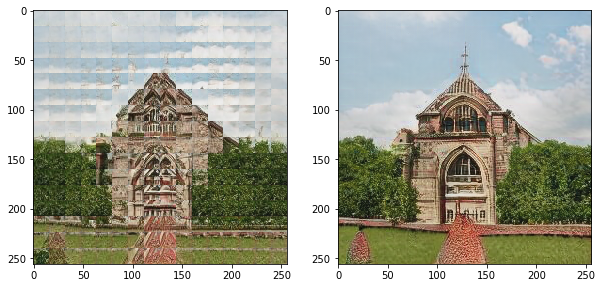

In [18]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(postproc(total)[0])
plt.subplot(1, 2, 2)
plt.imshow(postproc(sample)[0])